In [65]:
import matplotlib
import torch
import torch.nn.functional as F
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [67]:
input_signals_np = np.load('Data\InputSignals_RefData10_50.npy')
output_signals_np = np.load('Data\OutputSignals_RefData10_50.npy')
s_saturation_np = np.load('Data\S_saturation_sr20_Hrange10_50.npy')
x_saturated_np = np.load('Data\X_saturation_sr20_Hrange10_50.npy')

In [68]:
input_signals = torch.tensor(input_signals_np, dtype=torch.float64)
output_signals = torch.tensor(output_signals_np, dtype=torch.float64)
s_saturation = torch.tensor(s_saturation_np, dtype=torch.float64)
x_saturated = torch.tensor(x_saturated_np, dtype=torch.float64)

In [69]:
input_signals.shape, output_signals.shape, s_saturation.shape, x_saturated.shape

(torch.Size([5000, 11]),
 torch.Size([5000, 700]),
 torch.Size([5000, 9, 219]),
 torch.Size([5000, 6, 219]))

In [70]:
train = s_saturation[:1].permute(2,0,1).to(device)

In [71]:
target = x_saturated[:1].permute(2,0,1).to(device)

In [72]:
train.shape,target.shape

(torch.Size([219, 1, 9]), torch.Size([219, 1, 6]))

In [73]:
class RingsTrain(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(RingsTrain, self).__init__()
        self.lin = nn.Linear(9, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128,256)
        self.lin4 = nn.Linear(256,512)
        self.lin5 = nn.Linear(512,1024)
        self.lin6 = nn.Linear(1024,9)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()

    def forward(self, t,x):
        x = self.lrelu(self.lin(x))
        x = self.lrelu(self.lin2(x))
        x = self.tanh(self.lin3(x))
        x = self.lrelu(self.lin4(x))
        x = self.tanh(self.lin5(x))
        x = self.lin6(x)
        return x

In [74]:
time_intervals = torch.linspace(0, 20., 219).to(device)

(0.0, 220.0)

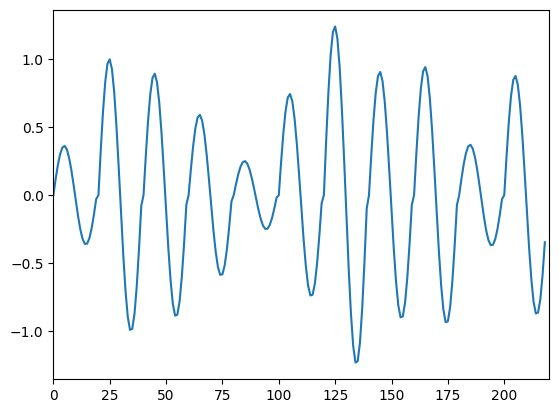

In [75]:
plt.plot(train[:,:,0].cpu(), label='Saturation')
plt.xlim(0, 220)

In [77]:
train.shape,target.shape

(torch.Size([219, 1, 9]), torch.Size([219, 1, 6]))

In [78]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time_intervals[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0, batch_t, batch_y

In [93]:
model = RingsTrain().double().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Iter 2960 | Total Loss 0.394809


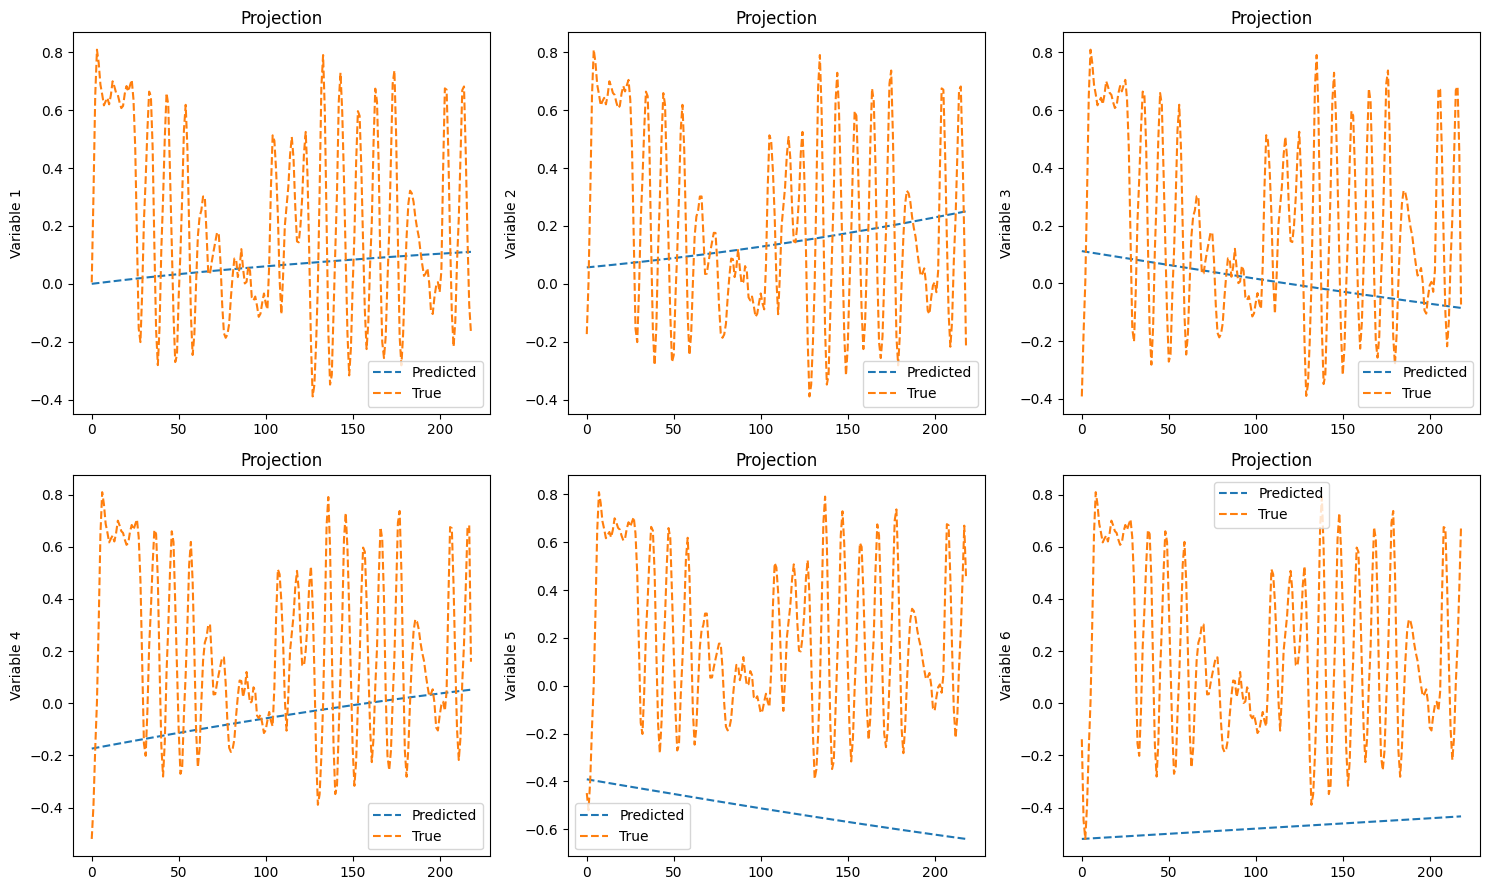

In [94]:
losses = []
whole_losses = []
best_loss = 100.0
for itr in range(3000):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(train,15)  # getting trajectory batch
    pred_y = odeint(model, batch_y0, batch_t)  # prediction using batch initial condition and batch time stamps
    loss = F.mse_loss(pred_y[:,:,3:], batch_y[:,:,3:])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), 'saved_models/rings_node_2.pth')
    if itr % 40 == 0:
        if itr > 1500:
            optimizer.param_groups[0]['lr'] = 1e-4
        with torch.no_grad():
            pred_y = odeint(model, train[0], time_intervals)
            loss = F.mse_loss(pred_y[:,:,3:], target)
            whole_losses.append(loss.item())
            fig, ax = plt.subplots(2, 3, figsize=(15, 9))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            for i in range(2):
                for j in range(3):
                    idx = i * 3 + j  # Index to access the corresponding variable
                    
                    ax[i, j].plot(pred_y[:, :, idx].cpu(), label='Predicted', linestyle='--')
                    ax[i, j].plot(target[:, :, idx].cpu(), label='True', linestyle='--')
                    ax[i, j].set_ylabel(f'Variable {idx + 1}')
                    ax[i, j].set_title('Projection')
                    ax[i, j].legend()

            # Adjust layout
            plt.tight_layout()
            plt.show()
            clear_output(wait=True)


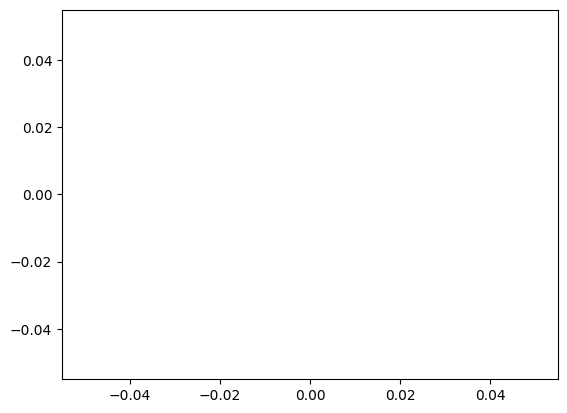

In [95]:
plt.plot(losses)

In [96]:
test_model = RingsTrain().double().to(device)

In [97]:
test_model.load_state_dict(torch.load('saved_models/rings_node_2.pth'))

<All keys matched successfully>

In [98]:
with torch.no_grad():
    traj = odeint(test_model,train[0],time_intervals)

In [102]:
traj.shape

torch.Size([219, 1, 6])

In [100]:
traj = traj[:,:,3:].cpu()
train = target.cpu()

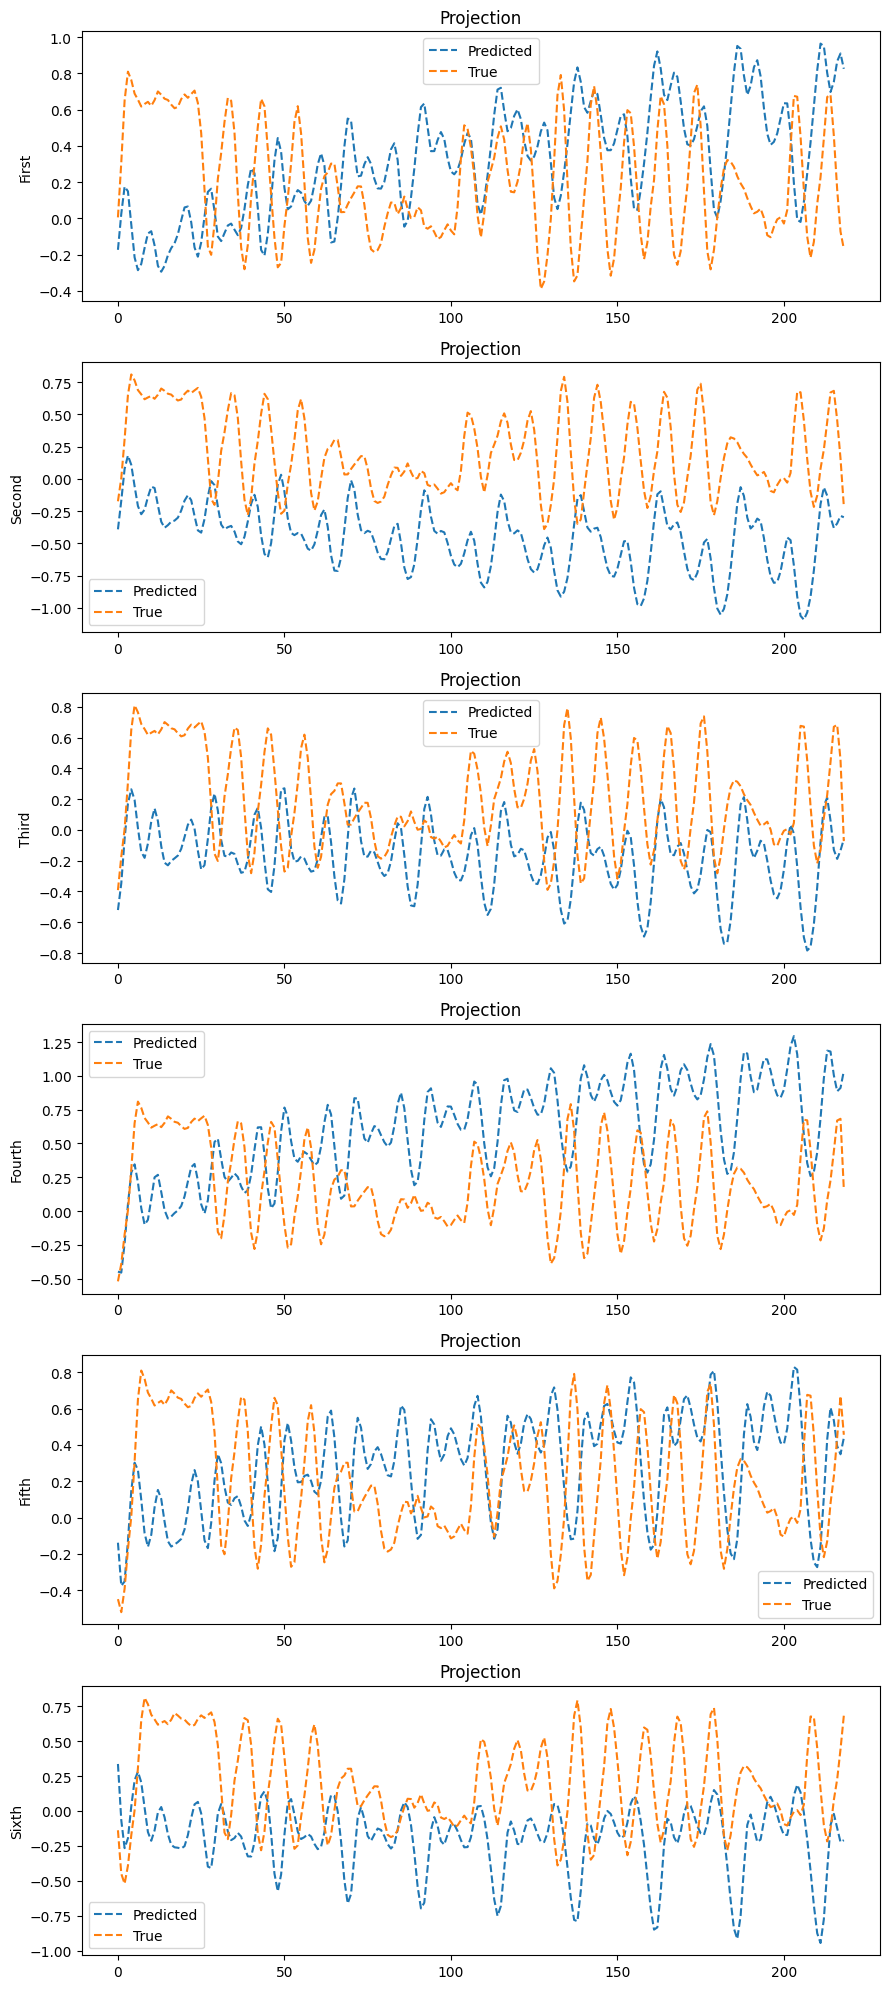

In [103]:
fig, ax = plt.subplots(6, 1, figsize=(9, 20))

ax[0].plot(traj[:,:,0], label='Predicted', linestyle='--')
ax[0].plot(train[:,:,0], label='True', linestyle='--')
ax[0].set_ylabel('First')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(traj[:,:,1], label='Predicted', linestyle='--')
ax[1].plot(train[:,:,1], label='True', linestyle='--')
ax[1].set_ylabel('Second')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(traj[:,:,2], label='Predicted', linestyle='--')
ax[2].plot(train[:,:,2], label='True', linestyle='--')
ax[2].set_ylabel('Third')
ax[2].set_title('Projection')
ax[2].legend()

ax[3].plot(traj[:,:,3], label='Predicted', linestyle='--')
ax[3].plot(train[:,:,3], label='True', linestyle='--')
ax[3].set_ylabel('Fourth')
ax[3].set_title('Projection')
ax[3].legend()

ax[4].plot(traj[:,:,4], label='Predicted', linestyle='--')
ax[4].plot(train[:,:,4], label='True', linestyle='--')
ax[4].set_ylabel('Fifth')
ax[4].set_title('Projection')
ax[4].legend()

ax[5].plot(traj[:,:,5], label='Predicted', linestyle='--')
ax[5].plot(train[:,:,5], label='True', linestyle='--')
ax[5].set_ylabel('Sixth')
ax[5].set_title('Projection')
ax[5].legend()


plt.tight_layout()
plt.show()